In [1]:
import torch
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("featurized_dataset.csv")

In [3]:
timeseries = data.Balance

In [2]:
full_data = pd.read_csv("Project 1_2024 - Data.csv")

In [3]:
timeseries = full_data[["Balance"]].values.astype("float32")

In [4]:
# train-test split for time series
train_size = int(len(timeseries) * 0.8)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [5]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [104]:
lookback = 15
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1219, 15, 1]) torch.Size([1219, 15, 1])
torch.Size([294, 15, 1]) torch.Size([294, 15, 1])


In [105]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=32, num_layers=2, batch_first=True, dropout=0.4)
        self.linear = nn.Linear(32, 1)
    def forward(self, x, debug = False):
        x, _ = self.lstm(x)
        if debug:
          print(x.shape)

        x = self.linear(x)
        return x

In [106]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [107]:
len(X_train)

1219

Будем считать градиенты по всему батчу -- с одной стороны это позволяет сделать спуск именно спуском, с другой стороны, благодаря дисперсии градиента при стохастике, можно получить лучшую генерализуемость на тесте -- в целом надо и так и так экспериментировать

In [108]:
import torch.optim as optim
import torch.utils.data as data

model = AirModel().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train),
                         batch_size=1203, drop_last=True)

n_epochs = 5000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device), debug=False)
        loss = loss_fn(y_pred, y_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train.to(device))
        train_mae = torch.max(np.abs(y_pred.cpu()[:, -1, :] - y_train[:, -1, :]), dim=0)[0].item()
        y_pred = model(X_test.to(device))
        test_mae = torch.max(np.abs(y_pred.cpu()[:, -1, :] - y_test[:, -1, :]), dim=0)[0].item()
    print("Epoch %d: train MAXAE %.4f, test MAXAE %.4f" % (epoch, train_mae, test_mae))

Epoch 0: train MAXAE 2.3552, test MAXAE 2.4791
Epoch 100: train MAXAE 2.3649, test MAXAE 2.2694
Epoch 200: train MAXAE 2.2796, test MAXAE 2.1704
Epoch 300: train MAXAE 2.2180, test MAXAE 2.2920
Epoch 400: train MAXAE 1.4525, test MAXAE 2.1984
Epoch 500: train MAXAE 1.4171, test MAXAE 2.2269
Epoch 600: train MAXAE 1.3361, test MAXAE 2.2154
Epoch 700: train MAXAE 1.2537, test MAXAE 2.1856
Epoch 800: train MAXAE 1.1721, test MAXAE 2.1084
Epoch 900: train MAXAE 1.1554, test MAXAE 2.0710
Epoch 1000: train MAXAE 1.1548, test MAXAE 2.0868
Epoch 1100: train MAXAE 1.1234, test MAXAE 2.0962
Epoch 1200: train MAXAE 1.0951, test MAXAE 2.1076
Epoch 1300: train MAXAE 1.0163, test MAXAE 2.1320
Epoch 1400: train MAXAE 0.9644, test MAXAE 2.1413
Epoch 1500: train MAXAE 0.9059, test MAXAE 2.1447
Epoch 1600: train MAXAE 0.8489, test MAXAE 2.1414
Epoch 1700: train MAXAE 0.7653, test MAXAE 2.1323
Epoch 1800: train MAXAE 0.7118, test MAXAE 2.1336
Epoch 1900: train MAXAE 0.6528, test MAXAE 2.1333
Epoch 2000: 

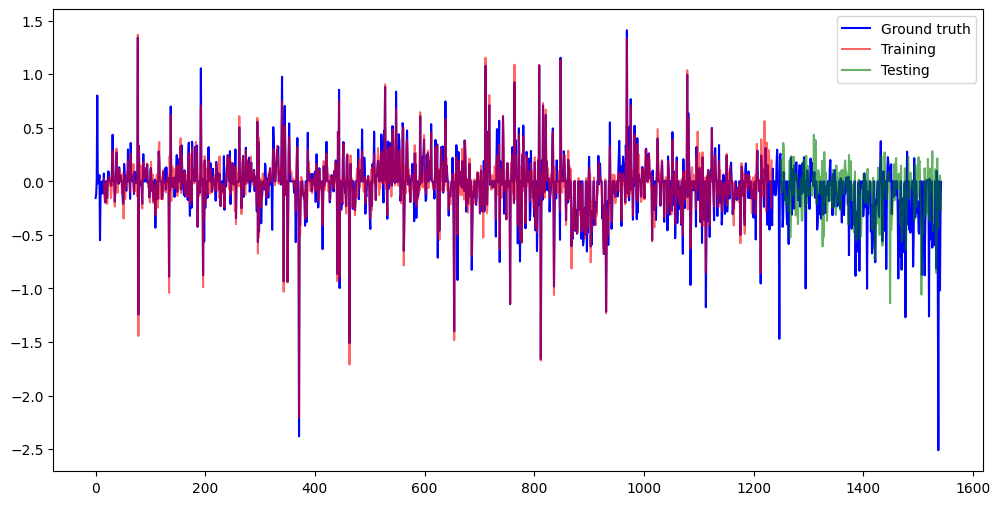

In [109]:
from matplotlib import pyplot as plt

model.to("cpu")

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.figure(figsize=(12, 6))
plt.plot(timeseries, c='b', label="Ground truth",)
plt.plot(train_plot, c='r', label="Training", alpha=0.6)
plt.plot(test_plot, c='g', label="Testing", alpha=0.6)
plt.legend()
plt.show()

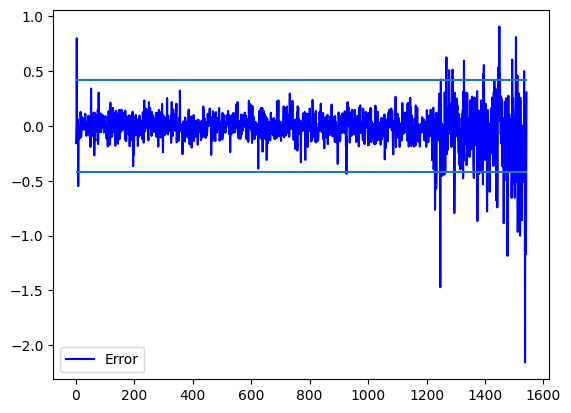

In [110]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.zeros_like(timeseries)
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.zeros_like(timeseries)
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

plt.plot(timeseries - train_plot - test_plot, c='b', label="Error")
plt.hlines(y = [-0.42, 0.42], xmin=0, xmax=len(timeseries))
plt.legend()
plt.show()